# _Building a prediction model based on text analysis of lyrics_
<hr style="height:2px;border-width:0;color:black;background-color:black">

#### Intro
This part of the project is the NLP (natural language processing) part.
We'll try to build a model that will allow prediction of a song's
genre by the song's lyrics.

We'll use the lyrics we scraped from the first part of the
project as the dataset we'll train a model on, and then test
it's accuracy.

For this purpose we'll need a few libraries:

`pip install pandas matplotlib seaborn sklearn nltk`

Next we'll need imports for all the libraries we're using:

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from numpy import random
from numpy import linalg as LA

from IPython.core.display import HTML

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from scipy import stats
from scipy.stats import zscore
from nltk import tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

%matplotlib inline

### NLTK

We'll be using a library called NLTK to process song lyrics text. This library requires dictionaries for certain workloads such as stopwords, punctuation etc. The next code patch downloads the correct dictionaries.

In [2]:
def download_nltk_packages():
    packages = ['vader_lexicon', 'stopwords', 'punkt', 'wordnet', 'omw-1.4']
    [nltk.download(package) for package in packages]

_ = download_nltk_packages()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Reading the input data

Next step is reading the data. The data is a bit dirty and we'll have to clean it up.

Part of the cleaning is removing duplicate songs (remixes, edits etc).

Some of the data is just plain bad for example irrelevant content as part of song's lyrics.

We'll also remove songs that are too short and genres for which we have too few songs

In [3]:
df = pd.read_csv('lyrics.csv')

# remove bad data
df.drop(df[df.genre.isna()].index, inplace=True)
df.drop(df[df.lyrics.str.contains('halliwell', regex=False, case=False)].index, inplace=True)

# remove remixes, edits
df.drop(df[df.title.str.contains('mix|edit', regex=True, case=False)].index, inplace=True)

# remove songs with lyrics duplicates or too short to analyze
df.drop(df[df.lyrics.str.len() < 400].index, inplace=True)
df.drop_duplicates(subset='lyrics', inplace=True)

# remove songs with rare genres ( under 100 songs )
df_genres = df.genre.value_counts().rename_axis('genre').to_frame('song_count')
low_frequency_genres = df_genres[df_genres['song_count'] < 200].index.to_numpy()
df.drop(df[df['genre'].isin(low_frequency_genres)].index, inplace=True)

# lowercase genres
df.genre = df.genre.str.lower()

### Overview of the data

Now that we cleaned the data we can take a quick overview on the resulting dataset
We can see that "rock" genre is by far the most popular, while some genres are
much less popular, we decided to trash some genres since the song count for those
was too low, especially for the ones with mixed genres.

We can also see there are clear outliers in song lengths, however those outliers
appear to be contributing to prediction accuracy of those specific genres, for example
the lyrics lengths for 'hiphop/rap' is on average much higher than other genres.

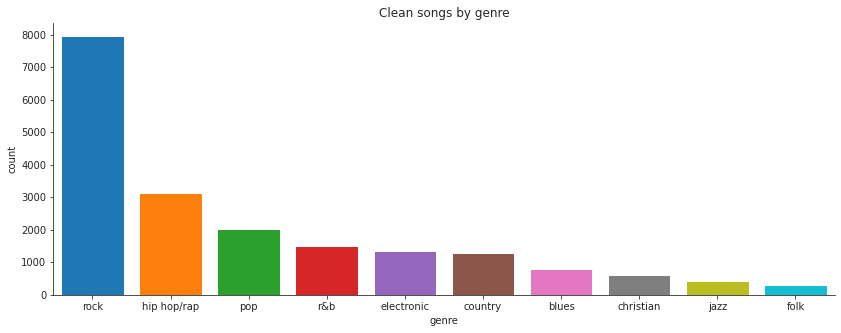

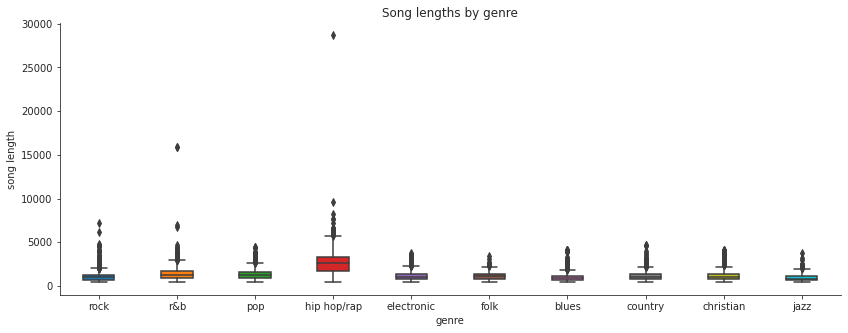

In [4]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(14, 5)
ax.set_title('Clean songs by genre')
sns.countplot(ax=ax, data = df, x = 'genre', saturation=1, order=df['genre'].value_counts().index)
sns.despine()

df_copy = df.copy()
df_copy['song length'] = df_copy.lyrics.transform(len)

fig, ax = plt.subplots()
ax.set_title('Song lengths by genre')
fig.set_size_inches(14, 5)
sns.boxplot(ax=ax, data = df_copy, x = 'genre', y = 'song length', saturation=1, width=0.4)
sns.despine()

### Setting up the model

Next, we'll need to set up a few things:
* We'll set up a tokenizer, this will allow us to tokenize words so that we can instruct the vectorizer on how to count them properly (e.g. split "wouldn't")
* We'll instruct our tokenizer to ignore words shorter than 3 characters or non-alphanumeric ones.
* We'll set up the "stop words" filter - these are words that are used too commonly in a language to be of use as they carry very little information by themselves. We'll also pass them through tokenizer so that they'll get the same preprocessing as the rest of the text.
* Finally we'll set up our vectorizer TfidfVectorizer using the above as it's settings, and a few other settings (ngrams, sublinear, min_df/max_df) that we found to be the best for this dataset using grid search.

We'll also split our dataset into train/test sets with 70%/30% split to prepare for next steps.

In [5]:
wnl = WordNetLemmatizer() # lemmatizer

def tokenizer(x): # custom tokenizer
    return (
        wnl.lemmatize(w) # only words that are  2 characters and is alpha-numeric
        for w in word_tokenize(x)
        if len(w) > 2 and w.isalnum()
    )

tokenized_stop_words = set()
for w in stopwords.words('english'):
    [tokenized_stop_words.add(sw) for sw in tokenizer(w)]

tfidfVectorizer = TfidfVectorizer(
        ngram_range = (1, 3), # include bigrams
        tokenizer = tokenizer,
        stop_words = tokenized_stop_words,
        sublinear_tf = True,
        lowercase = False,
        max_df = 0.4, # ignore terms that appear in more than 40% of documents
        min_df = 5) # ignore terms that appear in less than 4 documents

X_train, X_test, y_train, y_test = train_test_split(df.lyrics, df.genre, test_size = 0.3, random_state = 42)

### Helper methods setup:
* model_prepare will prepare a model pipeline using the vectorizer we created in previous step, scaler and specified classifier.
* model_display will use a given model to perform a prediction, and display the results;
    * Using classification report
    * Using a confusion matrix

To vectorize the song lyrics (text) into numerical data we'll use TfidfVectorizer as part of our pipeline.
This vectorizer is equvalent to CountVectorizer (counts word frequencies) followed by TfidfTransformer
which performs term frequency times inverse document frequency, this will provide 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

We'll be using MaxAbsScaler as it's designed to work with sparse data - our vectorizer output is sparse matrix of word frequencies.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html

The final step in the pipeline will be the classifier, this is a parameter because this pipeline
will work with any classifier that is able to accept sparse matrices and we tested a few.

In [6]:
def model_prepare(title, classifier):
    model = Pipeline([
        ('vect', tfidfVectorizer),
        ('scaler', MaxAbsScaler()),
        ('clf', classifier),
    ])
    model.title = title

    return model

def model_display(model, y_test, X_test, tags):
    pred = model.predict(X_test)

    print(classification_report(y_test, pred, target_names = df.genre.unique()))
    
    cm = confusion_matrix(y_test, pred, labels = tags)
    fig, ax = plt.subplots(figsize = (12, 8))
    axes = sns.heatmap(cm, annot = True, square = True, ax = ax, fmt='d', annot_kws={'size': 10})
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(model.title)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 0)
    _ = ax.xaxis.set_ticklabels(tags)
    _ = ax.yaxis.set_ticklabels(tags)

    return pred

### Model Choice

We considered several algorithms; KNN, MultinomialNB, Random Forest, LogisticRegression

The main requirement for the algorithm was ability to work with sparse matrix produced by TfIdf vectorizer
We chose 'precision' to be the main scoring for algorithm selection.

The algorithm that gave highest precision was [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

[MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) was runner up in second place with just a few percent lower precision than Logistic Regression.
However it's precision dropped sharply as the number of genres in the dataset increased.

[KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) had far lower precision (around 50%) for our dataset so we decided to drop it early.

[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) had lowest precision (under 40%) which also made us drop it early in the set.

Finally we settled on LogisticRegression algorithm, and used grid search to tune it's hyperparameters to reach around 70% precision.

              precision    recall  f1-score   support

        rock       0.72      0.71      0.72       238
         r&b       0.71      0.65      0.68       192
         pop       0.59      0.59      0.59       400
 hip hop/rap       0.52      0.44      0.48       422
  electronic       0.87      0.45      0.59        87
        folk       0.89      0.83      0.86       924
       blues       0.57      0.41      0.48       132
     country       0.50      0.56      0.53       618
   christian       0.71      0.69      0.70       449
        jazz       0.74      0.79      0.76      2367

    accuracy                           0.70      5829
   macro avg       0.68      0.61      0.64      5829
weighted avg       0.70      0.70      0.70      5829



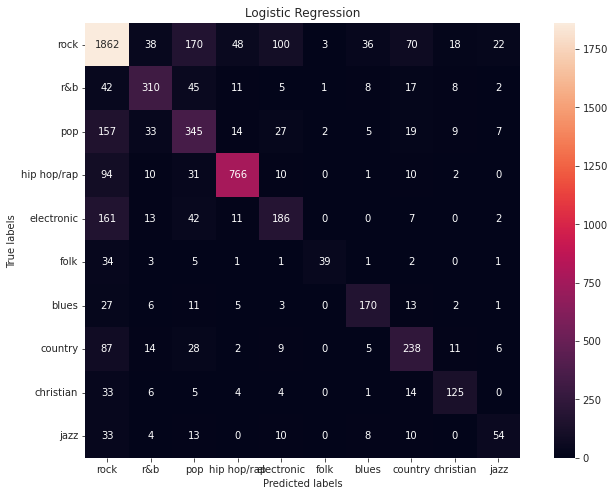

In [7]:
logic_clf = LogisticRegression(multi_class = "multinomial", C = 100.0, tol = 0.01, solver = "sag", class_weight = "balanced", random_state = 42)
logreg = model_prepare("Logistic Regression", logic_clf)
logreg.fit(X_train, y_train)
_ = model_display(logreg, y_test, X_test, df.genre.unique())

### Tuning

The next section is only relevant during tuning of a model - it uses GridSearchCV
to find the best parameters.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Due to gridsearch complexity raising combinatorically
with number of parameters it's best to test a few parameters at a time so that
search time remains reasonably short

In [8]:
def perform_tuning(model):
    tuned_parameters = [
        {'clf__tol': (0.01, 0.1)},
    ]
    for score in ["precision"]:
        print("# Tuning hyper-parameters for %s" % score)

        clf = GridSearchCV(model, tuned_parameters, scoring="%s_macro" % score, verbose=3)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print(clf.best_params_)
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

        print("Detailed classification report:")
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))

# perform_tuning(logreg)

### Conclusion

With english song lyrics there's a high chance to correctly predict the song's
genre based on word frequencies in lyrics alone, without analyzing rhythm or
any other musical qualities.

The cleaned dataset we analyzed had 10 genres, and majority of the data was
from the "rock" genre. This results in around 70% precision when trying to
predict the genre using the model we built. If we eliminate even more genres
with low song count in our dataset this causes the precision to rise, we
therefore concluded this is due to some genres lyrics being very close to
other genres causing false positives, while some genres e.g.
"new age"/"electronic" have relatively unique lyrics.